# CAR BEHAVIOURAL CLONING USING CNN

### By
* VISHWESHWAR PARAMESHWAR BHAT 
* RAM ABHINAV

In [1]:
# basic library
import pandas as pdp
import cv2, os
import random
import numpy as np
from sklearn.model_selection import train_test_split
import ntpath


#visualization
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# tensorflow
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Lambda, Convolution2D, MaxPooling2D, Dropout, Dense, Flatten,BatchNormalization

#hyperparameter tuning
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


In [2]:
#reading the data
df=pd.read_csv('driving_log.csv')
datadir=r'C:\Users\vishweshwar\Documents\carBehaviourCloning\IMG'

# renaming the columns
df.columns=['center','left','right','steering','throtle','brake','speed']
df.head()

<IPython.core.display.Javascript object>

,center,left,right,steering,throtle,brake,speed
0,C:\Users\vishweshwar\Documents\car-behavioral-...,C:\Users\vishweshwar\Documents\car-behavioral-...,C:\Users\vishweshwar\Documents\car-behavioral-...,0.0,0.0,0.0,0.000019
1,C:\Users\vishweshwar\Documents\car-behavioral-...,C:\Users\vishweshwar\Documents\car-behavioral-...,C:\Users\vishweshwar\Documents\car-behavioral-...,0.0,0.0,0.0,0.000005
2,C:\Users\vishweshwar\Documents\car-behavioral-...,C:\Users\vishweshwar\Documents\car-behavioral-...,C:\Users\vishweshwar\Documents\car-behavioral-...,0.0,0.0,0.0,0.000012
3,C:\Users\vishweshwar\Documents\car-behavioral-...,C:\Users\vishweshwar\Documents\car-behavioral-...,C:\Users\vishweshwar\Documents\car-behavioral-...,0.0,0.0,0.0,0.000011
4,C:\Users\vishweshwar\Documents\car-behavioral-...,C:\Users\vishweshwar\Documents\car-behavioral-...,C:\Users\vishweshwar\Documents\car-behavioral-...,0.0,0.0,0.0,0.000020


## ------------------------------------------VISULIZATION-----------------------------------------------

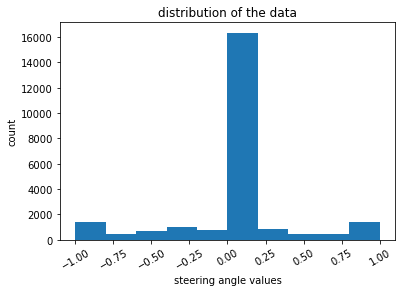

In [3]:
# data visulization
plt.hist(df.steering)
plt.title("distribution of the data")
plt.xlabel("steering angle values")
plt.ylabel('count')
plt.xticks(rotation=30)
plt.show()
# dataset is imbalanced

In [5]:
#Cleaning out the unnecessary paths in center left right columns
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

df['center'] = df['center'].apply(path_leaf)
df['left'] = df['left'].apply(path_leaf)
df['right'] = df['right'].apply(path_leaf)
df.head()

,center,left,right,steering,throtle,brake,speed
0,center_2021_09_20_16_57_10_817.jpg,left_2021_09_20_16_57_10_817.jpg,right_2021_09_20_16_57_10_817.jpg,0.0,0.0,0.0,0.000019
1,center_2021_09_20_16_57_10_886.jpg,left_2021_09_20_16_57_10_886.jpg,right_2021_09_20_16_57_10_886.jpg,0.0,0.0,0.0,0.000005
2,center_2021_09_20_16_57_10_961.jpg,left_2021_09_20_16_57_10_961.jpg,right_2021_09_20_16_57_10_961.jpg,0.0,0.0,0.0,0.000012
3,center_2021_09_20_16_57_11_033.jpg,left_2021_09_20_16_57_11_033.jpg,right_2021_09_20_16_57_11_033.jpg,0.0,0.0,0.0,0.000011
4,center_2021_09_20_16_57_11_104.jpg,left_2021_09_20_16_57_11_104.jpg,right_2021_09_20_16_57_11_104.jpg,0.0,0.0,0.0,0.000020


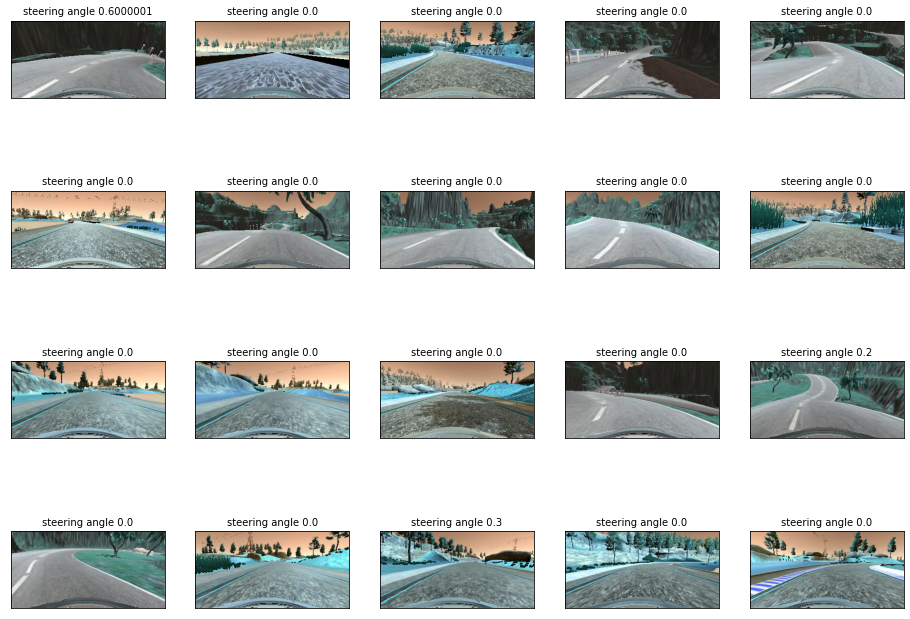

In [11]:
#visualization
plt.figure(figsize=(16,12))
for i in range(20):
    rdm_no=random.randint(0,len(df))
    plt.subplot(4,5,i+1,)
    pic=cv2.imread(os.path.join(datadir, df.center[rdm_no]))
    plt.imshow(pic)
    plt.title(label="steering angle"+" "+str(df.steering[rdm_no]),size=10,color="black")
    plt.xticks([])
    plt.yticks([])

In [12]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)


## ----------------- FUNCTIONS FOR PREPROCESSING----------------------

In [13]:
def load_image(dir, image_file):
    """
    Load RGB images from a file
    """
    return mpimg.imread(os.path.join(dir, image_file.strip()))


In [14]:
def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :, :] # remove the sky and the car front


In [15]:
def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)


In [16]:
def rgb2yuv(image):
    """
    Convert the image from RGB to YUV (This is what the NVIDIA model does)
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)


In [17]:
def preprocess(image):
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image


In [18]:
def choose_image(datadir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(datadir, left), steering_angle + 0.2
    elif choice == 1:
        return load_image(datadir, right), steering_angle - 0.2
    return load_image(datadir, center), steering_angle



In [19]:
def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle



In [20]:
def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle



In [21]:
def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtically and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle



In [22]:
def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


In [23]:
def augument(datadir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose_image(datadir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    #image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle


In [24]:
def batch_generator(datadir, image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 0.6:
                image, steering_angle = augument(datadir, center, left, right, steering_angle)
            else:
                image = load_image(datadir, center) 
            # add the image and steering angle to the batch
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers



## ----------------FUCTIONS FOR TRAINING AND SPLITING -----------------------

In [25]:
np.random.seed(0)


def load_data(datadir):
    """
    Load training data and split it into training and validation set
    """
    data_df = pd.read_csv(os.path.join(datadir, 'driving_log.csv'))

    X = df[['center', 'left', 'right']].values
    y = df['steering'].values

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

    return X_train, X_valid, y_train, y_valid


In [26]:
def build_model():
    """ 
    building the model
    
    """
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary()
    return model


In [27]:
def train_model(model,X_train, X_valid, y_train, y_valid,datadir,saving):
    """
    Train the model
    """
    callback=[EarlyStopping(monitor='val_loss',min_delta=0.01, patience=4,verbose=1),
            ModelCheckpoint(str(saving)+"_"+'model-{epoch:03d}.h5',monitor='val_loss',save_best_only=True,verbose=1),
            ReduceLROnPlateau(monitor='val_loss',factor=0.5,min_delta=0.001,verbose=1,patience=2)]
  
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001))

    return model.fit(batch_generator(datadir, X_train, y_train, 128, True),batch_size=128,epochs=15,
                     callbacks=[callback],steps_per_epoch=2000,
                     validation_data=batch_generator(datadir, X_valid, y_valid, 128, False),
                     verbose=1,validation_steps=200)


In [28]:
def Callback(save):
    """
    callbacks to avoid overfitting and saving the model
    """
    callback=[EarlyStopping(monitor='val_loss',min_delta=0.001, patience=4,verbose=1),
              ModelCheckpoint(str(save)+'_'+'model.h5',monitor='val_loss',save_best_only=True,verbose=1),
              ReduceLROnPlateau(monitor='val_loss',factor=0.5,min_delta=0.001,verbose=1,patience=2)]
    return callback

## ---- TRYING OUT DIFFERENT MODELS AND HYPER PARAMETR TUNING---

In [29]:
#splitting the data
X_train, X_valid, y_train, y_valid=load_data(datadir)
#building the model
model=build_model()
#training the model
train=train_model(model,X_train, X_valid, y_train, y_valid,datadir,"old")

<IPython.core.display.Javascript object>

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0

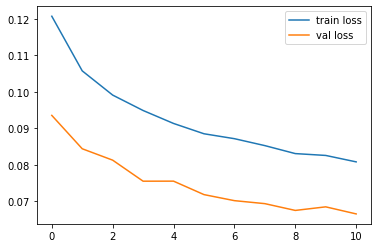

In [30]:
plt.plot(train.history['loss'], label='train loss')
plt.plot(train.history['val_loss'], label='val loss')
plt.legend()
plt.show()


In [111]:
def tuned_model(hp):
    """ building a rough model for hyper parameter tuning   """
    
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(Convolution2D(hp.Int("input",32,256,32), hp.Int("kernel_size_1" , 3, 5,2), (2, 2), input_shape=(128,66, 200, 3), activation='elu'))
    try:
        for i in range(hp.Int(f'n_layers',1,3,)):
            model.add(Convolution2D(hp.Int(f"conv_{i}_layer",32,128,8),hp.Int("kernel_size_2", 3, 5,2), (2, 2), activation='elu'))
    except Exception:
        pass
    try:
        for j in range(hp.Int('same_padded_layers',1,4,)):
            model.add(Convolution2D(hp.Int(f"same_padded_{i}_layer",32,96,16),(3,3),activation='elu'))
    except Exception:
        pass
    model.add(Dropout(hp.Choice("Drop out", [0.2, 0.3, 0.5])))
    model.add(Flatten())
    model.add(Dense(hp.Int("Dense_1",32,256,32), activation='elu'))
    model.add(Dense(hp.Int("Dense_2",20,120,20), activation='elu'))
    model.add(Dense(hp.Int("Dense_3",5,50,5), activation='elu'))
    model.add(Dense(1))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])))
    return model


In [117]:
# setting up the object for hyperparameter tuning
tuner=RandomSearch(tuned_model,
                  objective='val_loss',
                  max_trials=20,
                  directory='tuner')

INFO:tensorflow:Reloading Oracle from existing project tuner\untitled_project\oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 99, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 49, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 47, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 13, 47, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19552)             0         
________________________________

In [119]:
#searching the best hyper parameters
X_train, X_valid, y_train, y_valid=load_data(datadir)

tuner.search(batch_generator(datadir, X_train, y_train, 128, True),batch_size=128,epochs=5,
              steps_per_epoch=150,
              validation_data=batch_generator(datadir, X_valid, y_valid, 128, False),
              verbose=1,validation_steps=30)

<IPython.core.display.Javascript object>

INFO:tensorflow:Oracle triggered exit


In [120]:
# summary of hyperparameter
tuner.search_space_summary()

Search space summary
Default search space size: 16
input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
conv_0_layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 8, 'sampling': None}
kernel_size_2 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': None}
same_padded_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
same_padded_0_layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 16, 'sampling': None}
Drop out (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.5], 'ordered': True}
Dense_1 (Int)
{'default': 

In [124]:
#building the model with best hyperparameter
best_hps=tuner.get_best_hyperparameters()[0].values
best_hps

{'input': 160,
 'kernel_size_1': 5,
 'n_layers': 1,
 'conv_0_layer': 64,
 'kernel_size_2': 3,
 'same_padded_layers': 2,
 'same_padded_0_layer': 80,
 'Drop out': 0.5,
 'Dense_1': 128,
 'Dense_2': 60,
 'Dense_3': 45,
 'learning_rate': 0.001,
 'conv_1_layer': 72,
 'same_padded_1_layer': 64,
 'conv_2_layer': 32,
 'same_padded_2_layer': 64}

In [33]:
#getting state of the art models(imagenet models)
from tensorflow.keras.applications import ResNet50,MobileNet
#making the object for state of art models
mobilenet=MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(66, 200, 3))
#since the weights of the state of art models are well intialised
#hence we are training the  top of the model
for layer in resnet.layers:
    layer.trainable = False
for layer in mobilenet.layers:
    layer.trainable=False

In [34]:
def resnet_model():
    """
    building the resnet50 (imagenet model)
    """
    model = Sequential()
    model.add(resnet)
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=1e-4)
    model.compile(loss='mse', optimizer=optimizer)
    return model


In [36]:
#training the resnet model
resnetmodel1=resnet_model()
resnet1_history = resnetmodel1.fit(batch_generator(datadir, X_train, y_train, 128, True),batch_size=128,epochs=15,
                                 steps_per_epoch=2000,
                                 validation_data=batch_generator(datadir, X_valid, y_valid, 128, False),
                                 verbose=1,validation_steps=100,callbacks=Callback('resnet1-{epoch:03d}'))

Epoch 1/15
2000/2000 [==============================] - 656s 326ms/step - loss: 1.4297 - val_loss: 0.2110

Epoch 00001: val_loss improved from inf to 0.21095, saving model to resnet1-001_model.h5


C:\Users\vishweshwar\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/15
2000/2000 [==============================] - 672s 336ms/step - loss: 0.5242 - val_loss: 0.1485

Epoch 00002: val_loss improved from 0.21095 to 0.14853, saving model to resnet1-002_model.h5
Epoch 3/15
2000/2000 [==============================] - 693s 347ms/step - loss: 0.2733 - val_loss: 0.1178

Epoch 00003: val_loss improved from 0.14853 to 0.11775, saving model to resnet1-003_model.h5
Epoch 4/15
2000/2000 [==============================] - 687s 344ms/step - loss: 0.1714 - val_loss: 0.0994

Epoch 00004: val_loss improved from 0.11775 to 0.09940, saving model to resnet1-004_model.h5
Epoch 5/15
2000/2000 [==============================] - 820s 410ms/step - loss: 0.1322 - val_loss: 0.0894

Epoch 00005: val_loss improved from 0.09940 to 0.08940, saving model to resnet1-005_model.h5
Epoch 6/15
2000/2000 [==============================] - 699s 349ms/step - loss: 0.1176 - val_loss: 0.0832

Epoch 00006: val_loss improved from 0.08940 to 0.08322, saving model to resnet1-006_model.h5


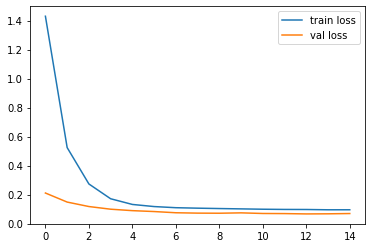

In [37]:
plt.plot(resnet1_history.history['loss'], label='train loss')
plt.plot(resnet1_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


In [ ]:
#trying out with different shape of the image
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 128, 128, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
X_train, X_valid, y_train, y_valid=load_data(datadir)
newmodel=build_model()
train2=train_model(newmodel,X_train, X_valid, y_train, y_valid,datadir,'new_model')

In [126]:
def tuned_new_model(hp):
    """
    for searchig the best hyperparameter
    """
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(Convolution2D(hp.Int("input",32,256,32), hp.Int("kernel_size_1" , 3, 5,2), (2, 2), input_shape=(128,66, 200, 3), activation='elu'))
    try:
        for i in range(hp.Int(f'n_layers',1,5,)):
            model.add(Convolution2D(hp.Int(f"conv_{i}_layer",32,128,8),hp.Int("kernel_size_2", 3, 5,2), (2, 2), activation='elu'))
    except Exception:
        pass
    try:
        for j in range(hp.Int('same_padded_layers',1,4,)):
            model.add(Convolution2D(hp.Int(f"same_padded_{i}_layer",32,96,16),(3,3),activation='elu'))
    except Exception:
        pass
    model.add(Dropout(hp.Choice("Drop out", [0.2, 0.3, 0.5])))
    model.add(Flatten())
    model.add(Dense(hp.Int("Dense_1",32,256,32), activation='elu'))
    model.add(Dense(hp.Int("Dense_2",20,120,20), activation='elu'))
    model.add(Dense(hp.Int("Dense_3",5,50,5), activation='elu'))
    model.add(Dense(1))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])))
    return model


In [132]:
#creating the object 
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 128, 128, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

new_tuner=RandomSearch(tuned_new_model,
                  objective='val_loss',
                  max_trials=20,
                  directory='new_tuner')

INFO:tensorflow:Reloading Oracle from existing project new_tuner\untitled_project\oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 63, 63, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 26912)             0         
____________________________

In [133]:
# searching for best hyperparameter
new_tuner.search(batch_generator(datadir, X_train, y_train, 128, True),batch_size=128,epochs=5,
              steps_per_epoch=150,
              validation_data=batch_generator(datadir, X_valid, y_valid, 128, False),
       
                 verbose=1,validation_steps=30)

INFO:tensorflow:Oracle triggered exit


In [80]:
#hyperparameters 
new_tuner.search_space_summary()

Search space summary
Default search space size: 20
input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
conv_0_layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 8, 'sampling': None}
kernel_size_2 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': None}
same_padded_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
same_padded_0_layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 16, 'sampling': None}
Drop out (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.5], 'ordered': True}
Dense_1 (Int)
{'default': 

In [81]:
#building the model with best hyperParameter
best_hps=new_tuner.get_best_hyperparameters()[0]
model = new_tuner.hypermodel.build(best_hps)
tuned_history2=train_model(model,X_train, X_valid, y_train, y_valid,datadir,"lasttuned")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 63, 63, 192)       5376      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 48)        230448    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 72)        86472     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 96)          172896    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 40)          96040     
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 40)          0

In [86]:
def imagenet_models(technique):
    """ 
    function for building the imagenet models
    """
    x=Dropout(0.2)(technique.output)
    x = Flatten()(x)
    x=Dropout(0.2)(x)
    x=Dense(100, activation='elu')(x)
    x=Dropout(0.3)(x)
    x= Dense(50, activation='elu')(x)
    x=Dense(10, activation='elu')(x)
    x=Dense(1)(x)
    optimizer = Adam(learning_rate=1e-3)
    model = Model(technique.input, x)
    model.compile(loss='mse', optimizer=optimizer,)
    return model


In [90]:
#building the mobilenet model
mobilenet_model=imagenet_models(mobilenet)
mobilenethistory = mobilenet_model.fit(batch_generator(datadir, X_train, y_train, 128, True),batch_size=128,epochs=15,
                                 steps_per_epoch=2000,
                                 validation_data=batch_generator(datadir, X_valid, y_valid, 128, False),
                                 verbose=1,validation_steps=100,callbacks=Callback('mobilenet'))

Epoch 1/15
2000/2000 [==============================] - 510s 254ms/step - loss: 0.1648 - val_loss: 0.1128

Epoch 00001: val_loss improved from inf to 0.11284, saving model to mobilenet_model.h5
Epoch 2/15
2000/2000 [==============================] - 503s 252ms/step - loss: 0.1021 - val_loss: 0.0868

Epoch 00002: val_loss improved from 0.11284 to 0.08685, saving model to mobilenet_model.h5
Epoch 3/15
2000/2000 [==============================] - 503s 251ms/step - loss: 0.0950 - val_loss: 0.0737

Epoch 00003: val_loss improved from 0.08685 to 0.07367, saving model to mobilenet_model.h5
Epoch 4/15
2000/2000 [==============================] - 504s 252ms/step - loss: 0.0897 - val_loss: 0.0770

Epoch 00004: val_loss did not improve from 0.07367
Epoch 5/15
2000/2000 [==============================] - 505s 253ms/step - loss: 0.0876 - val_loss: 0.0729

Epoch 00005: val_loss improved from 0.07367 to 0.07286, saving model to mobilenet_model.h5

Epoch 00005: ReduceLROnPlateau reducing learning rate

In [93]:
#finally building the resnet model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in resnet.layers:
    layer.trainable = False

resnetmodel2=resnet_model()
resnet2_history2 = resnetmodel2.fit(batch_generator(datadir, X_train, y_train, 128, True),batch_size=128,epochs=15,
                                 steps_per_epoch=2000,
                                 validation_data=batch_generator(datadir, X_valid, y_valid, 128, False),
                                 verbose=1,validation_steps=200,callbacks=Callback('resnet2-{epoch:03d}'))

Epoch 1/15
2000/2000 [==============================] - 652s 324ms/step - loss: 2.3837 - val_loss: 0.1557

Epoch 00001: val_loss improved from inf to 0.15571, saving model to resnet2-001_model.h5


C:\Users\vishweshwar\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/15
2000/2000 [==============================] - 644s 322ms/step - loss: 0.8846 - val_loss: 0.1516

Epoch 00002: val_loss improved from 0.15571 to 0.15158, saving model to resnet2-002_model.h5
Epoch 3/15
2000/2000 [==============================] - 637s 319ms/step - loss: 0.4054 - val_loss: 0.1401

Epoch 00003: val_loss improved from 0.15158 to 0.14012, saving model to resnet2-003_model.h5
Epoch 4/15
2000/2000 [==============================] - 634s 317ms/step - loss: 0.2294 - val_loss: 0.1285

Epoch 00004: val_loss improved from 0.14012 to 0.12851, saving model to resnet2-004_model.h5
Epoch 5/15
2000/2000 [==============================] - 665s 332ms/step - loss: 0.1628 - val_loss: 0.0967

Epoch 00005: val_loss improved from 0.12851 to 0.09671, saving model to resnet2-005_model.h5
Epoch 6/15
2000/2000 [==============================] - 666s 333ms/step - loss: 0.1302 - val_loss: 0.0890

Epoch 00006: val_loss improved from 0.09671 to 0.08898, saving model to resnet2-006_model.h5


# --------------------------------------THE END---------------------------------------------------

In [134]:
best_hps=new_tuner.get_best_hyperparameters()[0].values

In [135]:
best_hps

{'input': 192,
 'kernel_size_1': 3,
 'n_layers': 5,
 'conv_0_layer': 48,
 'kernel_size_2': 5,
 'same_padded_layers': 4,
 'same_padded_0_layer': 64,
 'Drop out': 0.2,
 'Dense_1': 64,
 'Dense_2': 40,
 'Dense_3': 15,
 'learning_rate': 0.001,
 'conv_1_layer': 72,
 'conv_2_layer': 96,
 'conv_3_layer': 40,
 'conv_4_layer': 40,
 'same_padded_4_layer': 48,
 'same_padded_2_layer': 64,
 'same_padded_3_layer': 48,
 'same_padded_1_layer': 80}

In [136]:
new_tuner.get_best_models(num_models=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 63, 63, 192)       5376      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 48)        230448    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 72)        86472     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 96)          172896    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 40)          96040     
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 40)          0